In [35]:
%load_ext autoreload
%autoreload 2

import IPython.display

import collections
import imageio
import os
import sys

import numpy as np
import PIL
import torch
import torchvision
from tqdm.auto import tqdm

import matplotlib.animation as animation
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../models'))
from DCGAN.model import initialize_weights, Generator, Discriminator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Config

In [57]:
IMAGE_SIZE = 64
BASE_FEATURES_DEPTH = 64
BATCH_SIZE = 32
LATENT_DIM = 100

BETA_1 = 0.5  # hyperparameter of Adam
LEARNING_RATE = 0.0002

device = torch.device('cuda:0')

# Data loading

In [52]:
def download_extended_dataset_from_wikiart():
    # Dowload the script that will manage the data procurement
    # https://github.com/lucasdavid/wikiart
    os.system("git clone https://github.com/lucasdavid/wikiart.git")
    os.system("python3 wikiart/wikiart.py --datadir ./wikiart-saved/ fetch --only artists")

    # Metadata to indicate the artist to be downloaded
    entry = '''[{
        "artistName": "Claude Monet",
        "birthDay": "/Date(-4074969600000)/",
        "birthDayAsString": "November 14, 1840",
        "contentId": 211667,
        "deathDay": "/Date(-1359331200000)/",
        "deathDayAsString": "December 5, 1926",
        "dictonaries": [
            1221,
            316
        ],
        "image": "https://uploads0.wikiart.org/00115/images/claude-monet/440px-claude-monet-1899-nadar-crop.jpg!Portrait.jpg",
        "lastNameFirst": "Monet Claude",
        "url": "claude-monet",
        "wikipediaUrl": "http://en.wikipedia.org/wiki/Claude_Monet"
    }]'''

    with open('./wikiart-saved/meta/artists.json', 'w') as artists_file:
        artists_file.write(entry)

    # Download the art from the artist
    os.system("python3 wikiart/wikiart.py --datadir ./wikiart-saved/ fetch")

    files = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk('wikiart-saved/images/claude-monet'):
        for file in f:
            if '.jpg' in file:
                files.append(os.path.join(r, file))

In [51]:
# download_extended_dataset_from_wikiart()

# EDA

In [53]:
image_folder = torchvision.datasets.ImageFolder(
    '../data/processed/DCGAN',
    transform=torchvision.transforms.Compose(
        (
           torchvision.transforms.Resize(IMAGE_SIZE),
           torchvision.transforms.CenterCrop(IMAGE_SIZE),
           torchvision.transforms.ToTensor(),
        )
    )
)

dataloader = torch.utils.data.DataLoader(
    image_folder, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=4
)

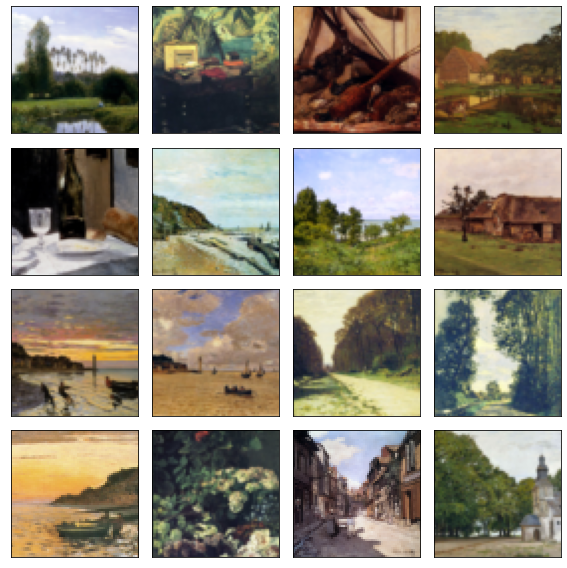

In [54]:
GRID_SIZE = 4

fig, axes = plt.subplots(
    GRID_SIZE, 
    GRID_SIZE, 
    figsize=(8, 8), 
    sharex='all', 
    sharey='all',
)

for i in range(axes.size):
    ax = axes[i // GRID_SIZE][i % GRID_SIZE]
    ax.imshow(
        (255 * image_folder[i][0].permute(1, 2, 0))
        .numpy()
        .astype(np.uint8)
    )
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()

# DCGAN

## Generator

In [58]:
generator = Generator(
    latent_space_dim=LATENT_DIM, 
    base_features_depth=BASE_FEATURES_DEPTH
).to(device)
generator.apply(initialize_weights)
optimizer_generator = torch.optim.Adam(
    generator.parameters(), 
    lr=LEARNING_RATE, 
    betas=(BETA_1, 0.999)
)

## Discriminator

In [59]:
discriminator = Discriminator(
    base_features_depth=BASE_FEATURES_DEPTH
).to(device)
discriminator.apply(initialize_weights);
optimizer_discriminator = torch.optim.Adam(
    discriminator.parameters(), 
    lr=LEARNING_RATE, # needs to be increased if SpectralNorm is used
    betas=(BETA_1, 0.999)
)

## Training loop

In [ ]:
num_epochs = 50
loss_fn = torch.nn.BCELoss()
fixed_noize = torch.randn(
    64, LATENT_DIM, 1, 1, 
    dtype=torch.float32, device=device
)

FAKE_LABEL = 0
REAL_LABEL = 1

img_list = []
G_losses = []
D_losses = []
iter_counter = 0

for epoch in tqdm(range(num_epochs), desc='epoch'):
    for batch_id, batch in enumerate(dataloader):
        # 1. Update discriminator 
        discriminator.zero_grad()
        # 1.1. Run in on real data.
        # Batch = (data, dummy label).
        real_paintings = batch[0].to(device) 
        batch_size = real_paintings.size(0)
        labels = torch.full(
            (batch_size, ), REAL_LABEL, 
            dtype=torch.float32, device=device
        ) 
        
        predicted_proba = discriminator(real_paintings).view(-1)
        D_loss_real = loss_fn(predicted_proba, labels)
        D_loss_real.backward()
        
        # 1.2. Run it on fake data
        noise = torch.randn(
            batch_size, LATENT_DIM, 1, 1, 
            dtype=torch.float32, device=device
        )
        fake_paintings = generator(noise)
        labels.fill_(FAKE_LABEL)
        predicted_proba = discriminator(fake_paintings.detach()).view(-1)
        D_loss_fake = loss_fn(predicted_proba, labels)
        D_loss_fake.backward()
        
        D_loss = D_loss_real + D_loss_fake
        optimizer_discriminator.step()
        D_losses.append(D_loss.detach().cpu().item())
        
        # 2. Update generator
        generator.zero_grad()
        # Generator tries to maximize the probability of misclassification
        predicted_proba = discriminator(fake_paintings).view(-1)
        labels.fill_(REAL_LABEL)
        # Here the gradients of discriminator are already set to 0,
        G_loss = loss_fn(predicted_proba, labels)
        G_loss.backward()
        optimizer_generator.step()
        G_losses.append(G_loss.detach().cpu().item())
        
    with torch.no_grad():
        img_list.append(
            generator(fixed_noize)
            [0]
            .permute(1, 2, 0)
            .cpu()
            .numpy()
        )

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
imageio.mimwrite(
    'DCGAN.gif',
    [
        (255 * img.clip(0, 1)).astype(np.uint8)
        for img in img_list
    ], 
    fps=1
)

In [ ]:
IPython.display.Image(url='DCGAN.gif')